In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

In [2]:
arousal = pd.read_csv("../data/annotations/arousal_cont_average.csv", index_col = 0) # This will be our target
annotations = annotations = pd.read_csv("../data/annotations/songs_info.csv", index_col = 0)
annotations.Genre = annotations.Genre.str.strip()

train_ids = annotations.index[annotations["Mediaeval 2013 set"] == "development"]
test_ids = annotations.index[annotations["Mediaeval 2013 set"] == "evaluation"]

print(f"{len(train_ids)} train cases | {len(test_ids)} test cases")

619 train cases | 125 test cases


# Pop subset

In [3]:
# Let's take a subset first

pop_train = annotations.index[(annotations.Genre == "Pop") & (annotations["Mediaeval 2013 set"] == "development")]
pop_test = annotations.index[(annotations.Genre == "Pop") & (annotations["Mediaeval 2013 set"] == "evaluation")]

pop_train, pop_test

(Int64Index([757, 759, 764, 767, 769, 773, 775, 776, 777, 779, 780, 781, 782,
             787, 790, 791, 794, 795, 796, 798, 799, 800, 801, 804, 805, 806,
             807, 808, 811, 813, 814, 815, 819, 820, 823, 825, 830, 831, 833,
             834, 836, 839, 841, 845, 846, 848, 850, 851, 852, 854, 856, 857,
             858, 859, 860, 863, 864, 865, 866, 867, 869, 871, 872, 873, 874],
            dtype='int64', name='song_id'),
 Int64Index([756, 758, 763, 784, 789, 797, 810, 818, 824, 826, 829, 844, 855], dtype='int64', name='song_id'))

In [4]:
sample_song = np.loadtxt("../data/default_features/2.csv", delimiter = ";", skiprows = 1)
sample_song = sample_song[30:,1:] # Skippoing first 15 sec with 2 Hz AND omitting the first col with timestamp
print(sample_song.shape)
sample_song

(61, 6669)


array([[1.958121e+00, 3.000000e+00, 2.600000e+01, ..., 8.984880e+04,
        1.681433e+02, 5.000000e+01],
       [1.317112e+00, 4.900000e+01, 4.400000e+01, ..., 9.285108e+04,
        1.939829e+02, 5.000000e+01],
       [2.165915e+00, 2.000000e+01, 1.200000e+01, ..., 8.346525e+04,
        1.418656e+02, 5.000000e+01],
       ...,
       [2.099028e+00, 2.100000e+01, 3.800000e+01, ..., 1.068915e+05,
        1.428836e+02, 5.000000e+01],
       [2.480069e+00, 3.700000e+01, 3.100000e+01, ..., 8.014771e+04,
        1.573234e+02, 5.000000e+01],
       [1.038606e+00, 0.000000e+00, 4.000000e+00, ..., 5.835529e+04,
        2.415684e+02, 5.000000e+01]])

In [5]:
X_raw = []
for song_id in pop_train:
    song_features = np.loadtxt(f"../data/default_features/{song_id}.csv", delimiter = ";", skiprows = 1)
    song_features = song_features[30:,1:] # Skippoing first 15 sec with 2 Hz AND omitting the first col with timestamp
    X_raw.append(song_features)

X_raw = np.concatenate(X_raw)
X_raw.shape

(3965, 6669)

In [6]:
X_test_raw = []
for song_id in pop_test:
    song_features = np.loadtxt(f"../data/default_features/{song_id}.csv", delimiter = ";", skiprows = 1)
    song_features = song_features[30:,1:] # Skippoing first 15 sec with 2 Hz AND omitting the first col with timestamp
    X_test_raw.append(song_features)

X_test_raw = np.concatenate(X_test_raw)
X_test_raw.shape

(793, 6669)

In [7]:
y = arousal.loc[pop_train].to_numpy().flatten()
y.shape

(3965,)

In [8]:
y_test = arousal.loc[pop_test].to_numpy().flatten()
y_test.shape

(793,)

# Scaling

Without scaling, there are problems with convergence.
Also, it improves performance

In [9]:
print(X_raw.mean(axis = 0), X_raw.std(axis = 0))

[3.26392560e+00 2.24559899e+01 2.56052963e+01 ... 1.30382849e+05
 1.84795688e+02 5.00000000e+01] [2.07715936e+00 1.59354116e+01 1.60918650e+01 ... 1.03741800e+05
 7.48182304e+01 0.00000000e+00]


In [10]:
scaler = StandardScaler()
scaler.fit(X_raw)
X = scaler.transform(X_raw)
X_test = scaler.transform(X_test_raw)

print(X.mean(axis = 0), X.std(axis = 0))

[-3.05038326e-15  9.66580046e-17 -1.51259137e-16 ... -1.22513741e-15
 -1.42648958e-15  0.00000000e+00] [1. 1. 1. ... 1. 1. 0.]


In [11]:
def rmse(model, X, y):
    return sqrt(mean_squared_error(y, model.predict(X)))

def print_rmse(model):
    print(f"RMSE train: {rmse(model, X, y):.4f} RMSE test: {rmse(model, X_test, y_test):.4f}")

# SVR
Scores the best results, but still, RMSE 0.2 is not too good

In [12]:
svr = svm.SVR(cache_size = 4000)
svr.fit(X, y)

SVR(cache_size=2000)

In [13]:
print_rmse(svr)

RMSE train: 0.0770 RMSE test: 0.2092


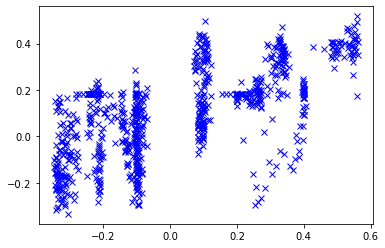

In [14]:
y_predict = svr.predict(X_test)

plt.plot(y_test, y_predict, "bx")

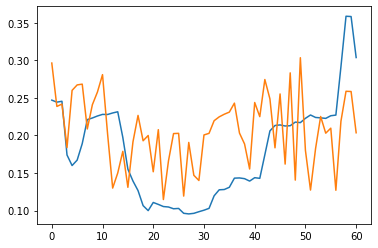

In [30]:
pred = svr.predict(X[:61])
real = arousal.loc[pop_train[0]]

plt.plot(real.to_numpy())
plt.plot(pred)

# Looks bad

## Linear SVR
Should scale better, but fails to converge

In [ ]:
lin_svr = svm.LinearSVR(max_iter = 10000)
lin_svr.fit(X, y)

In [132]:
print_rmse(lin_svr)

RMSE train: 0.0247 RMSE test: 0.9859


# Linear models

## OLS

Clearly overfits

In [112]:
ols = linear_model.LinearRegression()
ols.fit(X, y)

LinearRegression()

In [113]:
print_rmse(ols)

RMSE train: 0.0000 RMSE test: 2.2605


## Ridge

In [114]:
ridge = linear_model.Ridge(alpha=0.5)
ridge.fit(X, y)

Ridge(alpha=0.5)

In [115]:
print_rmse(ridge)

RMSE train: 0.0197 RMSE test: 0.8400


In [126]:
for a in [0.01, 0.1, 1, 10, 100]:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X, y)
    print(a, end = " ")
    print_rmse(ridge)

0.01 RMSE train: 0.0018 RMSE test: 2.0631
0.1 RMSE train: 0.0099 RMSE test: 1.3413
1 RMSE train: 0.0242 RMSE test: 0.7328
10 RMSE train: 0.0401 RMSE test: 0.5335


/home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05281962772220794, tolerance: 0.024434740338627157
  positive)
.

100 RMSE train: 0.0583 RMSE test: 0.3121


## Lasso

In [123]:
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X, y)

Lasso(alpha=0.01)

In [124]:
print_rmse(lasso)

RMSE train: 0.1448 RMSE test: 0.2315


/home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06322771791194981, tolerance: 0.024434740338627157
  positive)
.

In [122]:
for a in [0.01, 0.1, 1, 10]:
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(X, y)
    print(a, end = " ")
    print_rmse(lasso)

0.01 RMSE train: 0.1448 RMSE test: 0.2315
0.1 RMSE train: 0.2134 RMSE test: 0.2573


/home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0559641723661084, tolerance: 0.024434740338627157
  positive)
.

1 RMSE train: 0.2830 RMSE test: 0.2652
10 RMSE train: 0.2830 RMSE test: 0.2652


## Lasso w/o standardization

In [102]:
lasso_raw = linear_model.Lasso(alpha=0.5)
lasso_raw.fit(X_raw, y)

/home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.77267518045329, tolerance: 0.03175972138051706
  positive)


Lasso(alpha=0.5)

In [103]:
print(f"RMSE train: {sqrt(mean_squared_error(y, lasso_raw.predict(X_raw))):.4f} RMSE test: {sqrt(mean_squared_error(y_test, lasso_raw.predict(X_test_raw))):.4f}")

RMSE train: 0.1051 RMSE test: 0.2486


## Lasso CV
Uses cross validation to find the best alpha, but takes ages to fit

In [119]:
lasso_cv = linear_model.LassoCV(verbose = True, n_jobs = 4)
lasso_cv.fit(X, y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................................................/home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0368099663643946, tolerance: 0.028643655222077385
  positive)
./home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029524140175379188, tolerance: 0.025386794933698668
  positive)
./home/jan/anaconda

./home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024657169505934107, tolerance: 0.02198420039218861
  positive)
./home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052980355688921676, tolerance: 0.028643655222077385
  positive)
./home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027076332360092437, tolerance: 0.026273931990625058
  positive)
./home/jan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

KeyboardInterrupt: 

In [ ]:
lasso_cv.alpha_

In [ ]:
print_rmse(lasso_cv)

# Full dataset

Takes ages

In [36]:
X_raw = []
for song_id in train_ids:
    song_features = np.loadtxt(f"../data/default_features/{song_id}.csv", delimiter = ";", skiprows = 1)
    song_features = song_features[30:,1:] # Skippoing first 15 sec with 2 Hz AND omitting the first col with timestamp
    X_raw.append(song_features)

X_raw = np.concatenate(X_raw)
X_raw.shape

(37759, 6669)

In [37]:
X_test_raw = []
for song_id in test_ids:
    song_features = np.loadtxt(f"../data/default_features/{song_id}.csv", delimiter = ";", skiprows = 1)
    song_features = song_features[30:,1:] # Skippoing first 15 sec with 2 Hz AND omitting the first col with timestamp
    X_test_raw.append(song_features)

X_test_raw = np.concatenate(X_test_raw)
X_test_raw.shape

(7625, 6669)

In [43]:
y = arousal.loc[train_ids].to_numpy().flatten()
y.shape

(37759,)

In [45]:
y_test = arousal.loc[test_ids].to_numpy().flatten()
y_test.shape

(7625,)

In [47]:
print(X_raw.mean(axis = 0), X_raw.std(axis = 0))

[2.91567191e+00 2.23851532e+01 2.59795810e+01 ... 1.22404492e+05
 1.81330822e+02 4.99916576e+01] [1.88833947e+00 1.57507851e+01 1.62488146e+01 ... 9.70201038e+04
 7.17651648e+01 6.26412906e-01]


In [48]:
scaler = StandardScaler()
scaler.fit(X_raw)
X = scaler.transform(X_raw)
X_test = scaler.transform(X_test_raw)

print(X.mean(axis = 0), X.std(axis = 0))

[-2.02650471e-16  4.15262635e-16 -8.28690530e-17 ... -2.39679271e-14
 -5.38155905e-15 -4.14344300e-15] [1. 1. 1. ... 1. 1. 1.]


In [ ]:
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X, y)

In [ ]:
print_rmse(lasso)